In [1]:
from datetime import datetime, timedelta
import os

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import json

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    Geometry,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

from utils import plot_image

c:\Users\agand\OneDrive\Escritorio\lakes\lake-algae-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = SHConfig()

config.sh_client_id = "cc4a81b4-0c9b-4d5c-af22-c642387084f3"
config.sh_client_secret = "CpnRHLDivxHIrARixPBBeLC8jlDOOfDs"

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [3]:
def get_config():
    config = SHConfig()

    config.sh_client_id = "43cc92ed-4c79-4d1f-8d83-39ddd1b5d2d2"
    config.sh_client_secret = "j59JOW0okkn8kpMQwnTxlZy5p8Anr3nN"
    return config

In [3]:
def get_image(osmid, type_image, date, config):

    ## Get evalscript
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    evalscripts = os.path.join(parent_directory, 'evalscripts')

    if type_image.upper() == 'WATER':
        type_image = 'ndwi.js'
    elif type_image.upper() == 'CHL':
        type_image = 'chlorophyll.js'
    elif type_image.upper() == 'TRUE':
        type_image = 'true-color.js'
    elif type_image.upper() == 'CLOUD':
        type_image = 'cloud.js'

    evalscript_path = os.path.join(evalscripts, type_image)
    with open(evalscript_path, 'r') as file:
        evalscript = file.read()

    ## Get geojson
    aois_path = os.path.join(parent_directory, 'aoi')
    geojson_path = os.path.join(aois_path, f'{osmid}.geojson')
    print(geojson_path)
    gdf = gpd.read_file(geojson_path)

    with open(geojson_path, 'r') as file:
        aoi = json.load(file)

    geometry = Geometry(aoi, crs=CRS.WGS84)

    minx, miny, maxx, maxy = gdf.total_bounds
    bbox = BBox(bbox=[minx, miny, maxx, maxy], crs='EPSG:4326')
    resolution = 5
    # sukhna_bbox = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS.WGS84)
    polygon_size = bbox_to_dimensions(bbox, resolution=resolution)
    print(polygon_size)

    max_size = max(polygon_size)
    aux = max_size
    i = 1
    while aux > 2500:
        i += 1
        aux = max_size
        aux = aux / i
        

    print(aux)

    resolution = 5*i
    polygon_size = bbox_to_dimensions(bbox, resolution=resolution)
    print(polygon_size)

    date_string = date.strftime('%Y-%m-%d')

    request_color = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(date_string, date_string),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=bbox,
        geometry=geometry,
        size=polygon_size,
        config=config,
    )

    raw_image = request_color.get_data()
    image = raw_image[0]
    return image






In [4]:
image = get_image(1601368, 'chl', datetime(2020, 6, 13), config)

c:\Users\agand\OneDrive\Escritorio\lakes\lake-algae-analysis\aoi\1601368.geojson
(7693, 7789)
1947.25
(1923, 1947)


In [6]:
image.shape

(1947, 1923, 4)

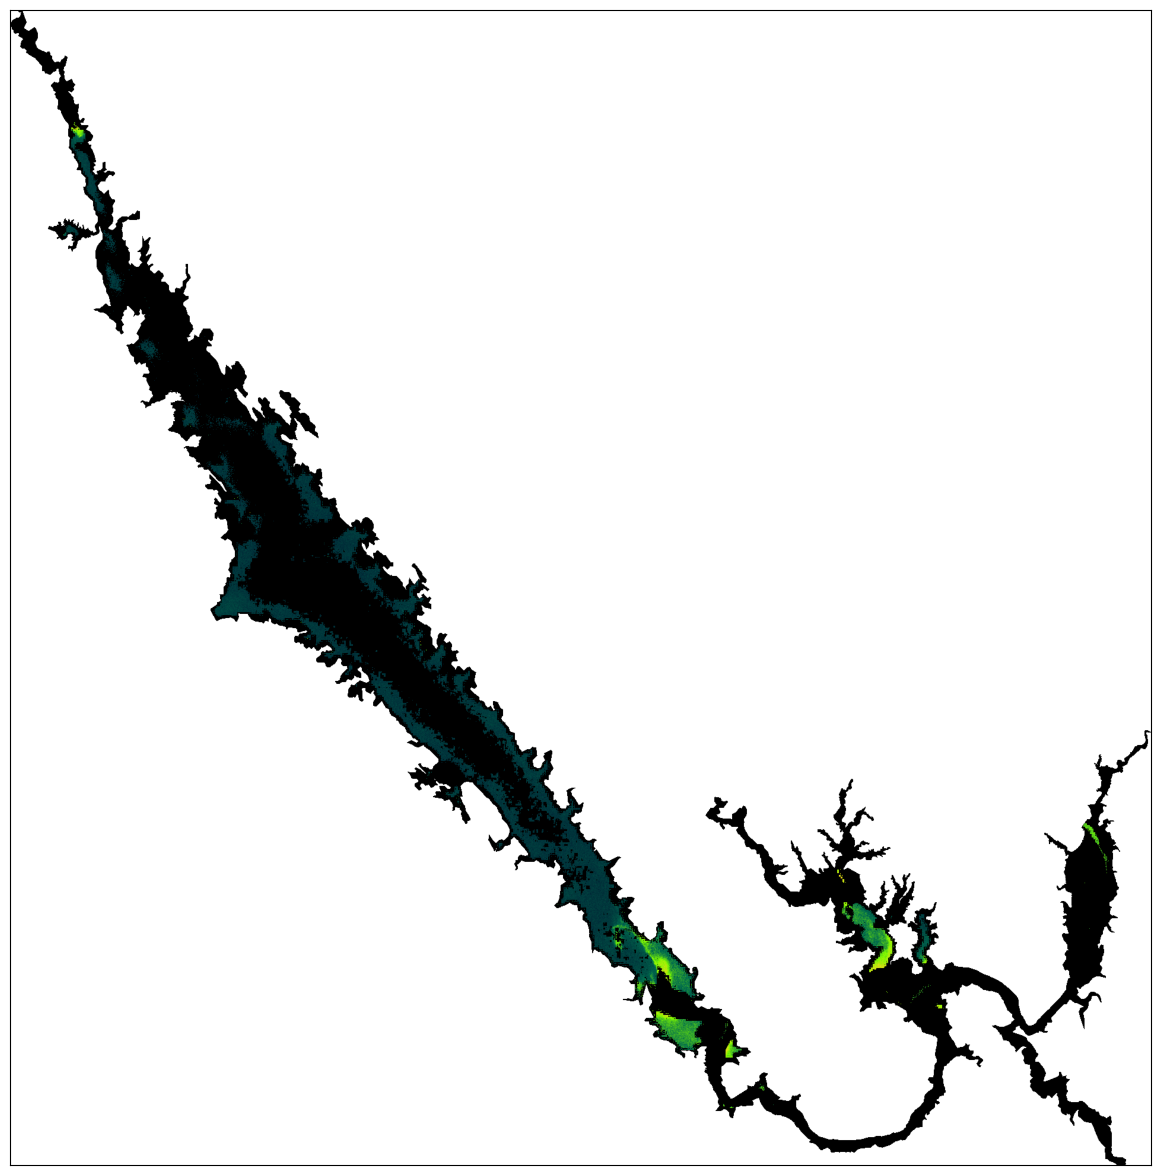

In [5]:
plot_image(image, factor=1/255, clip_range=(0, 1))

In [8]:
np.save('1601368_chl_2020-06-13_res20.npy', image)

In [14]:
type(image)
len(image)

print(image)

[[[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 ...

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]
  ...
  [255 255 255   0]
  [255 255 255   0]
  [255 255 255   0]]]


In [41]:
def get_all_images(lake, type_image, from_date, to_date, config):
    images = []
    for i in range(5):
        current_date = from_date + timedelta(days=i)
        image = get_image(lake, 'chl', current_date, config)
        if not np.all(image == 0):
            if type_image.lower() == 'c':
                images.append(image)
            else:
                image = get_image(lake, type_image, current_date, config)
            selected_day = current_date + timedelta(days = 5)
            break
            
    while selected_day <= to_date:
        image = get_image(lake, type_image, selected_day, config)
        images.append(image)
        selected_day += timedelta(days=5)

    return images


In [42]:
images = get_all_images('Sukhna lake', 'true', datetime(2020, 5, 1), datetime(2020, 8, 1), config)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


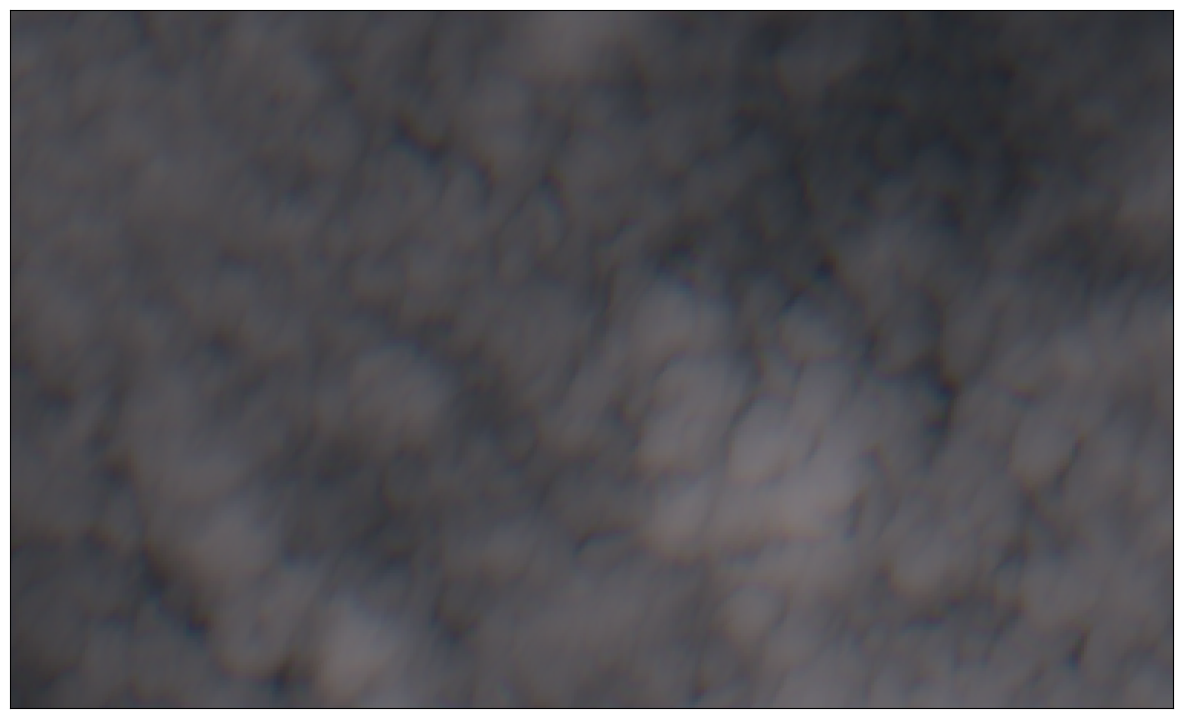

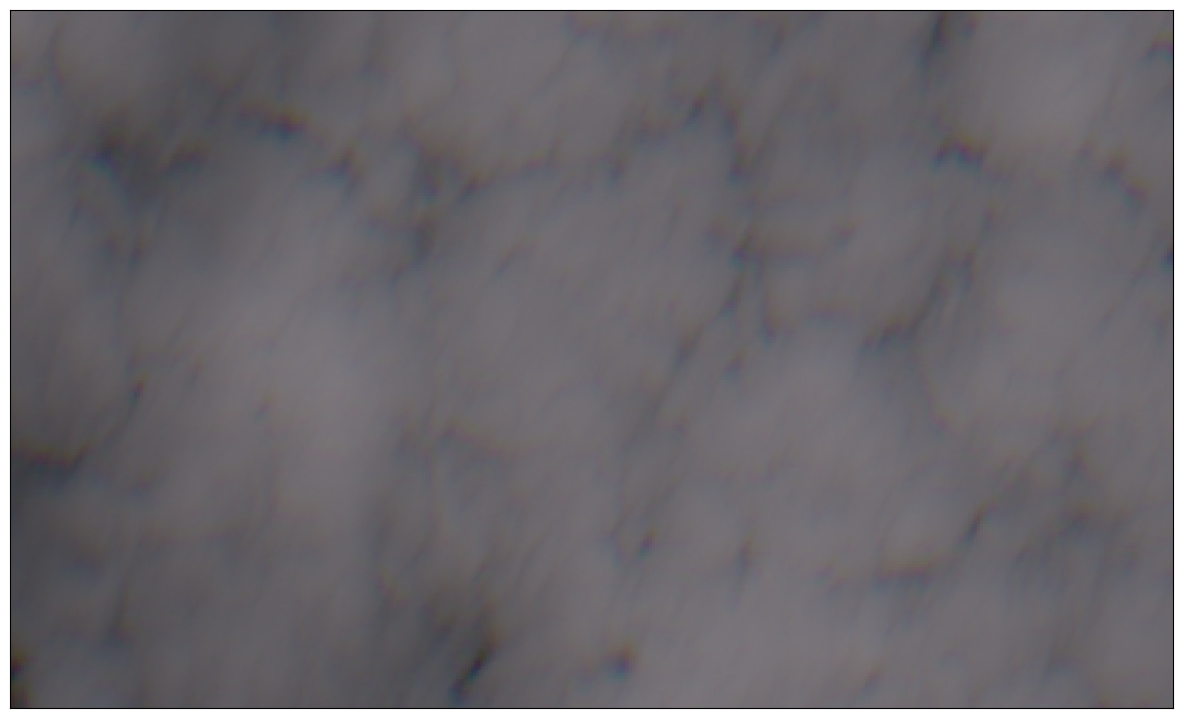

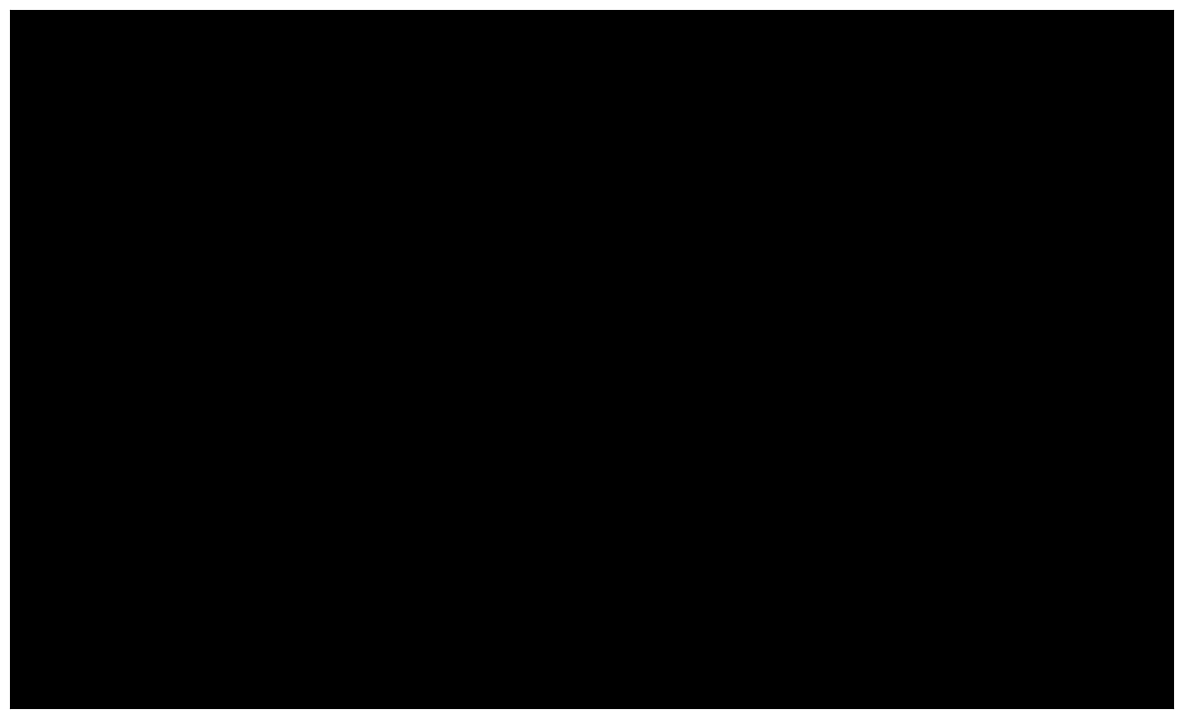

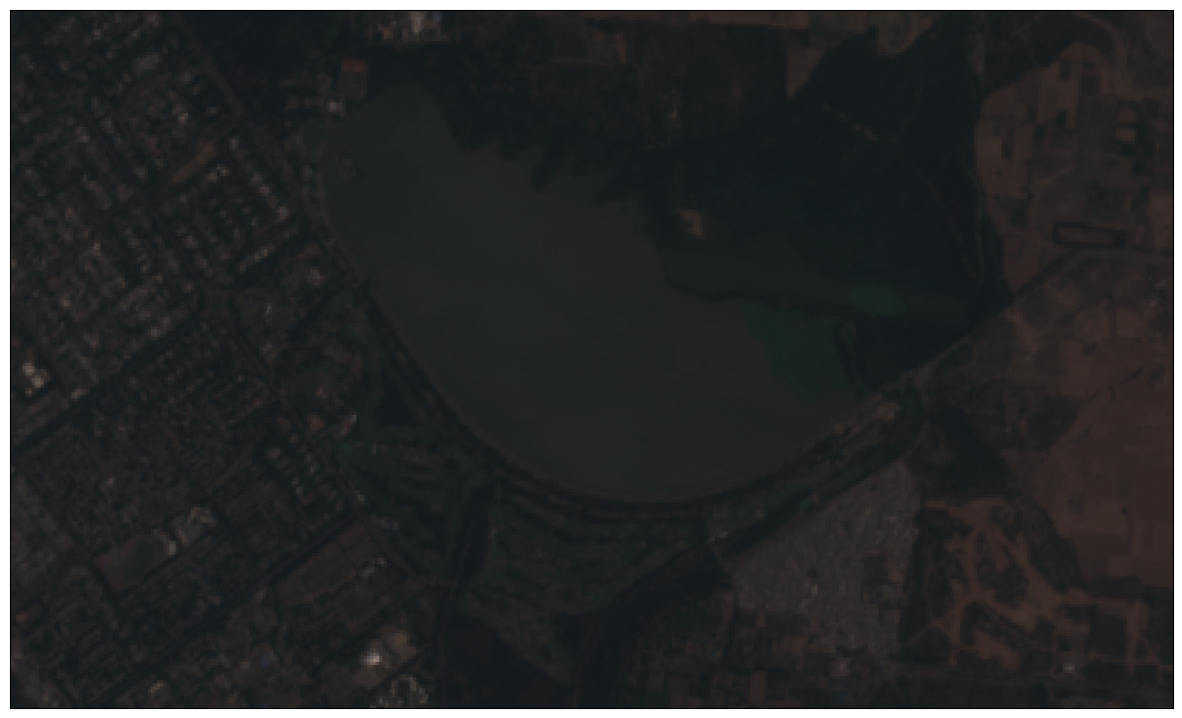

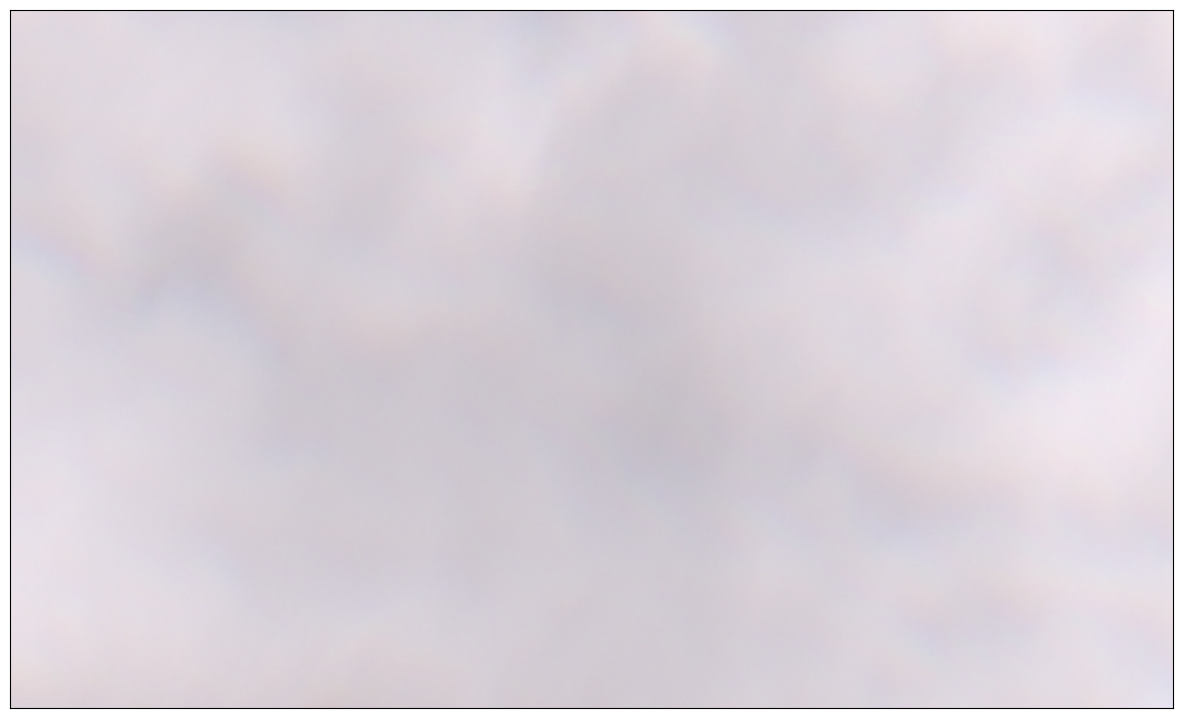

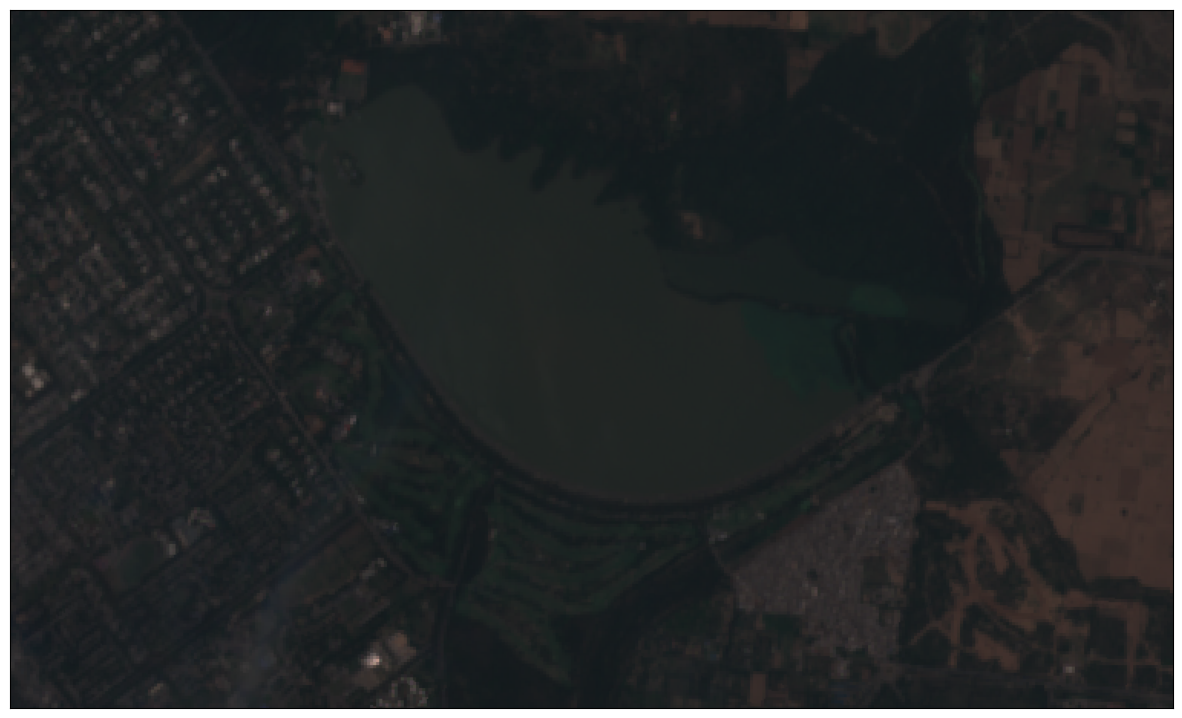

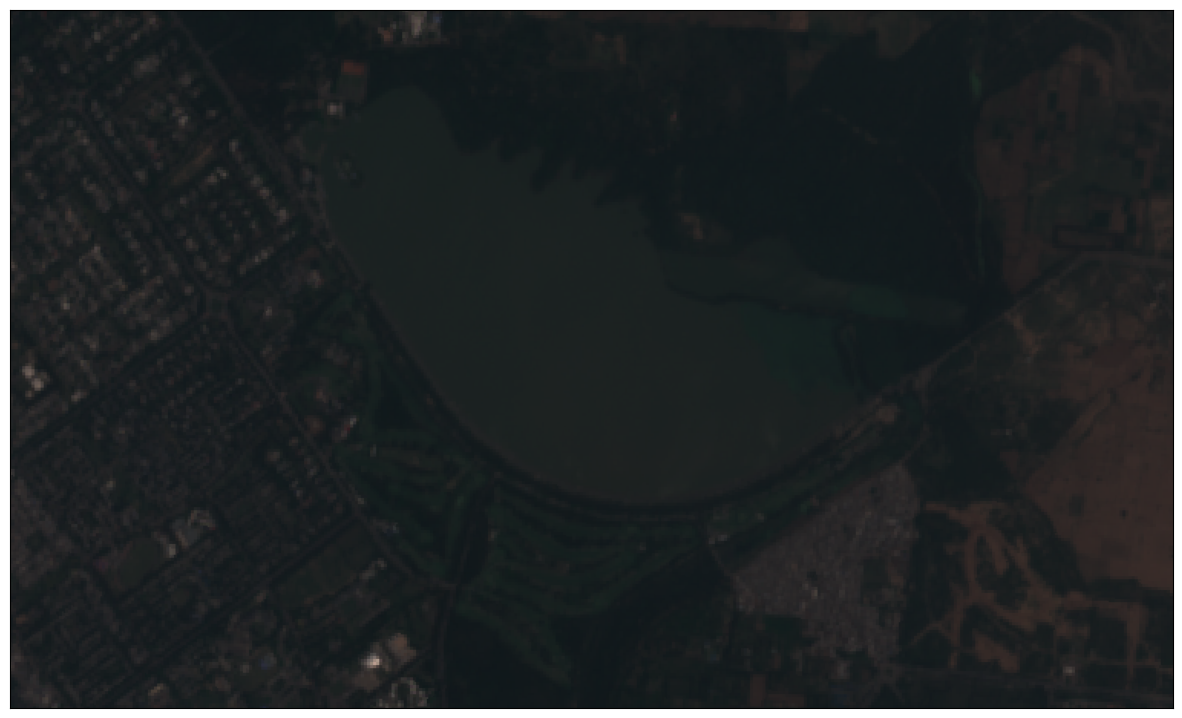

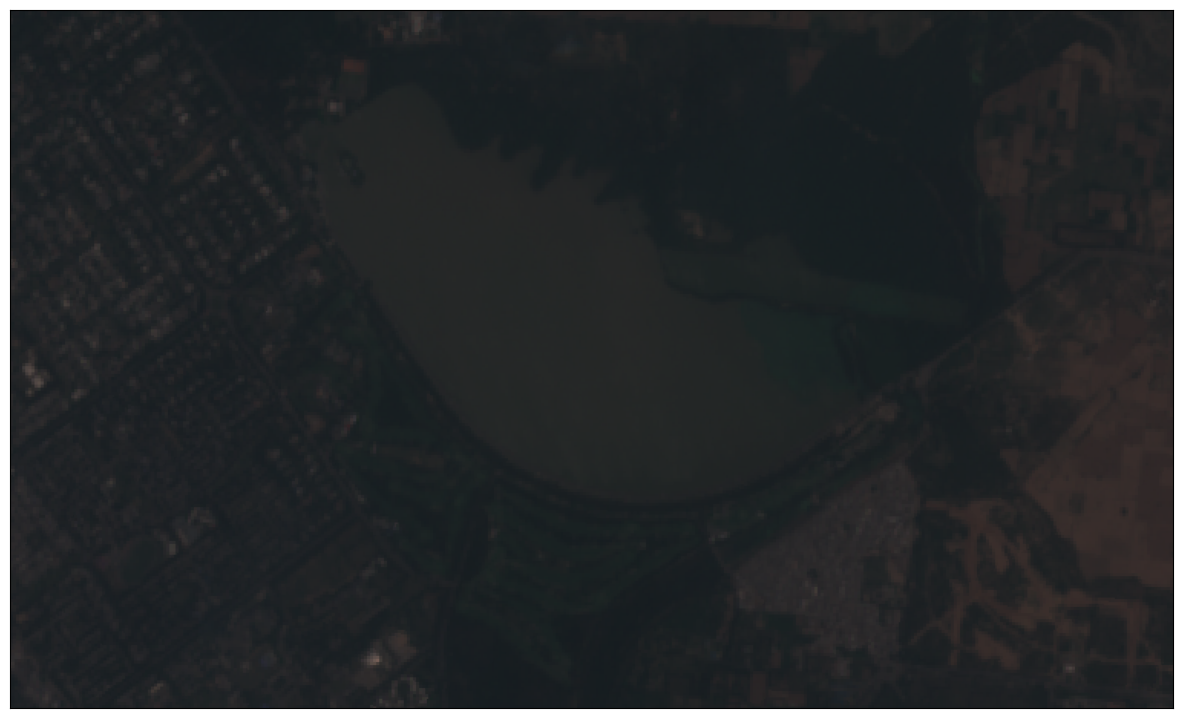

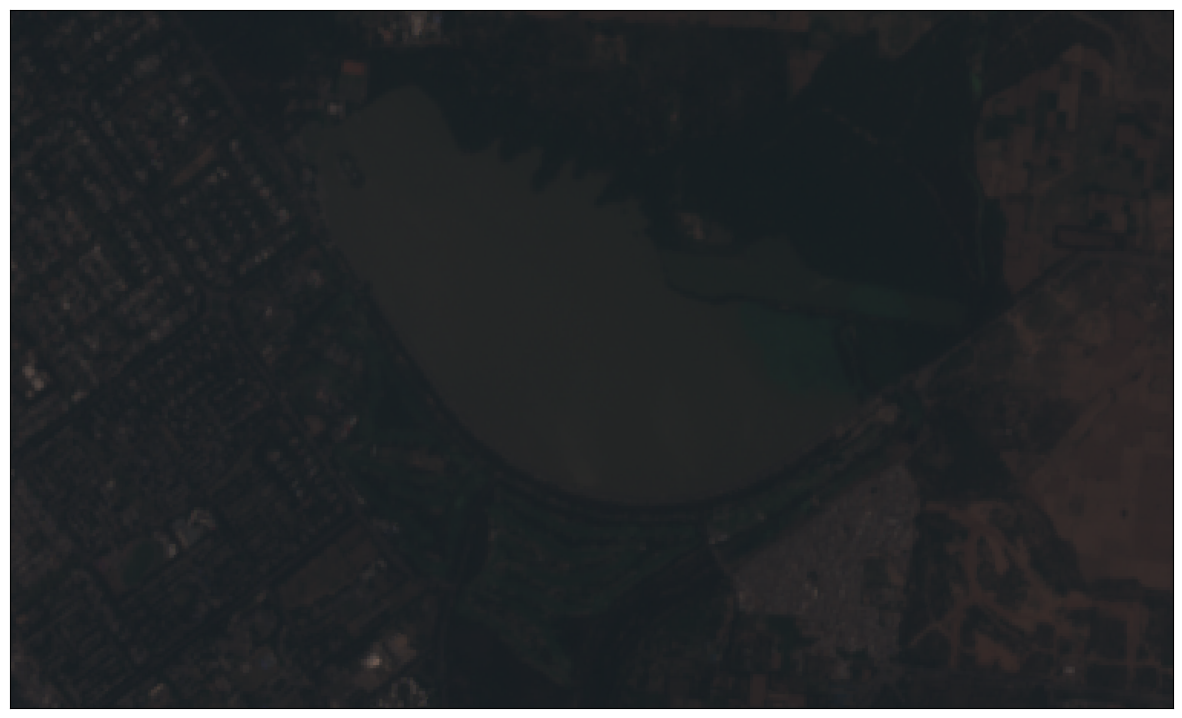

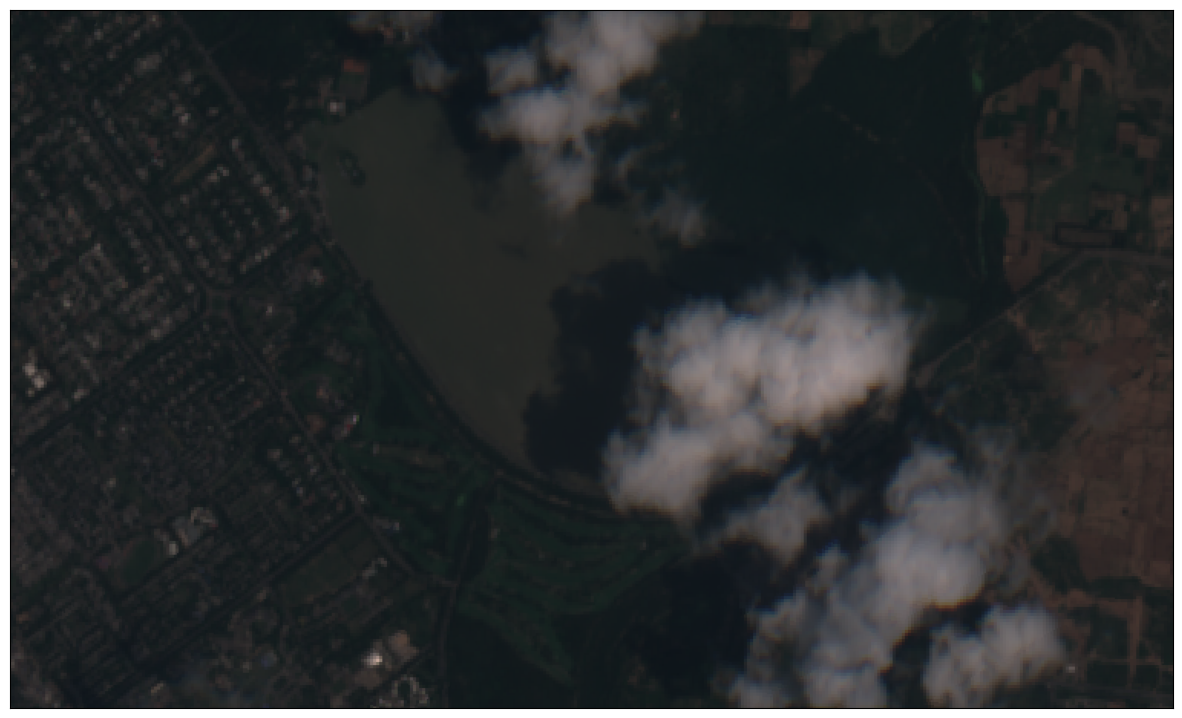

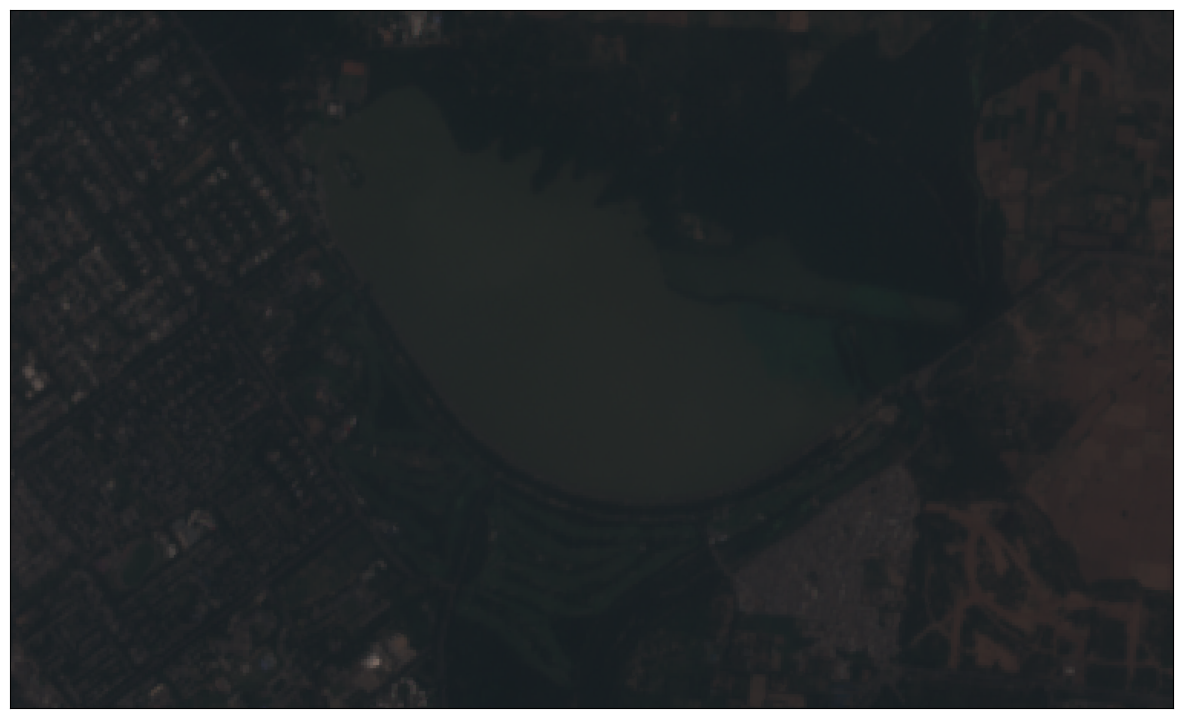

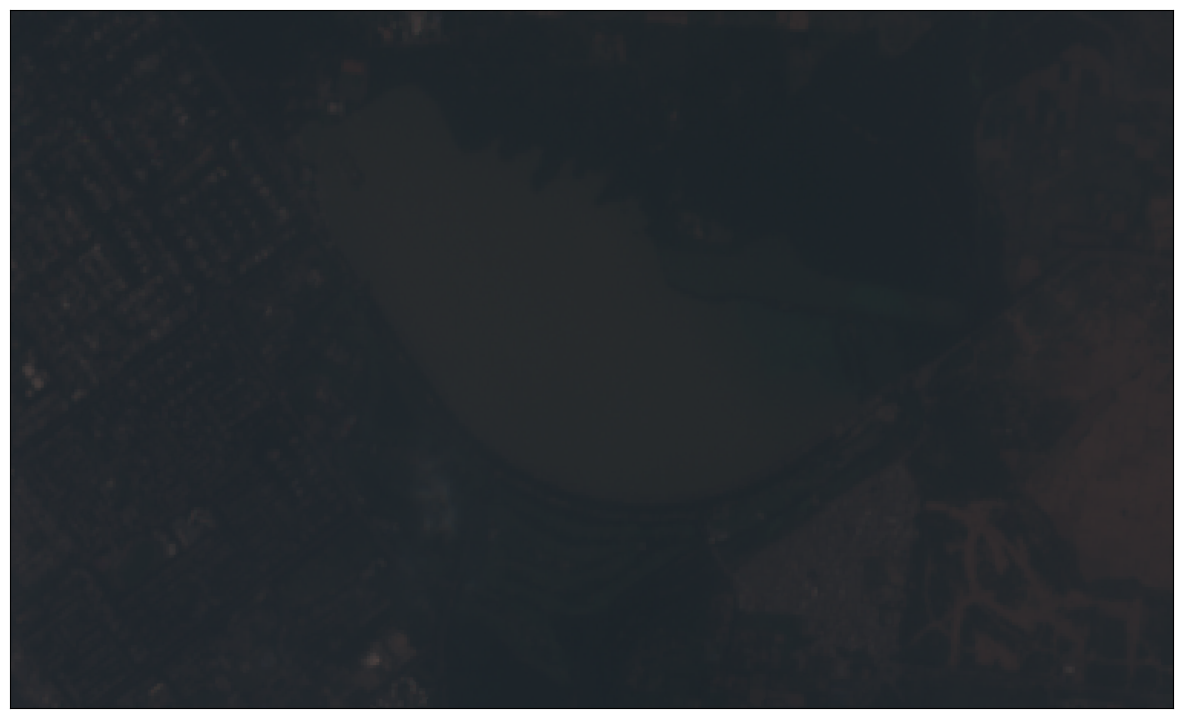

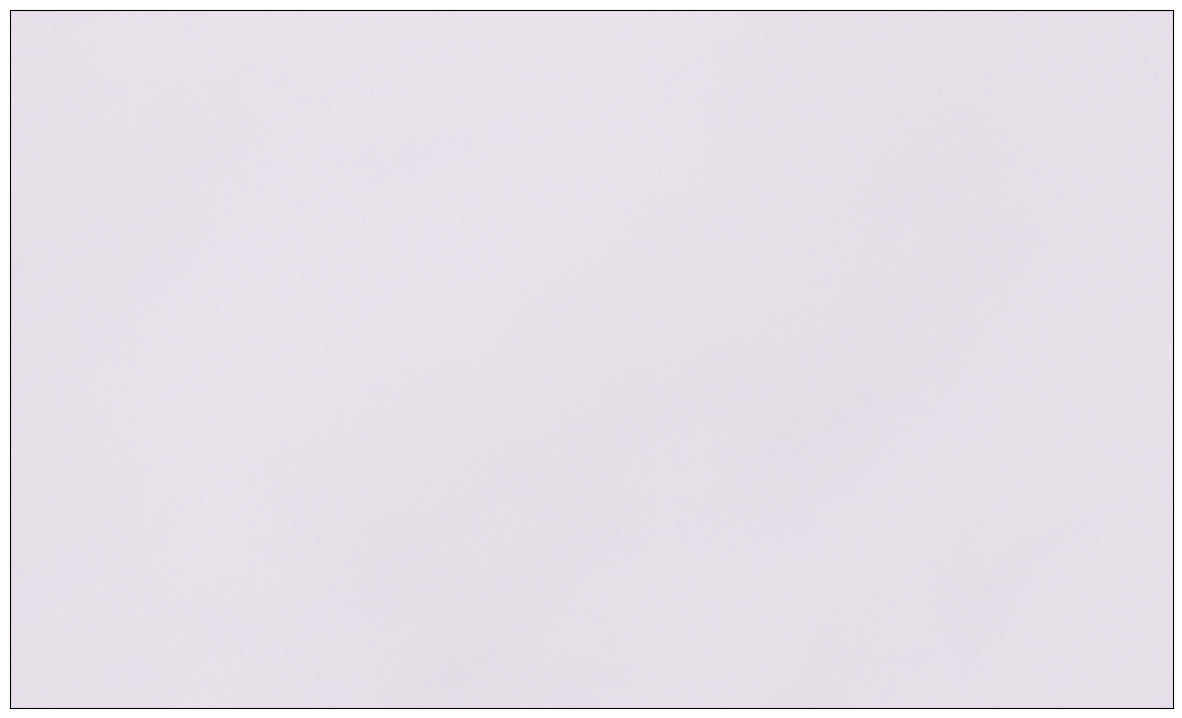

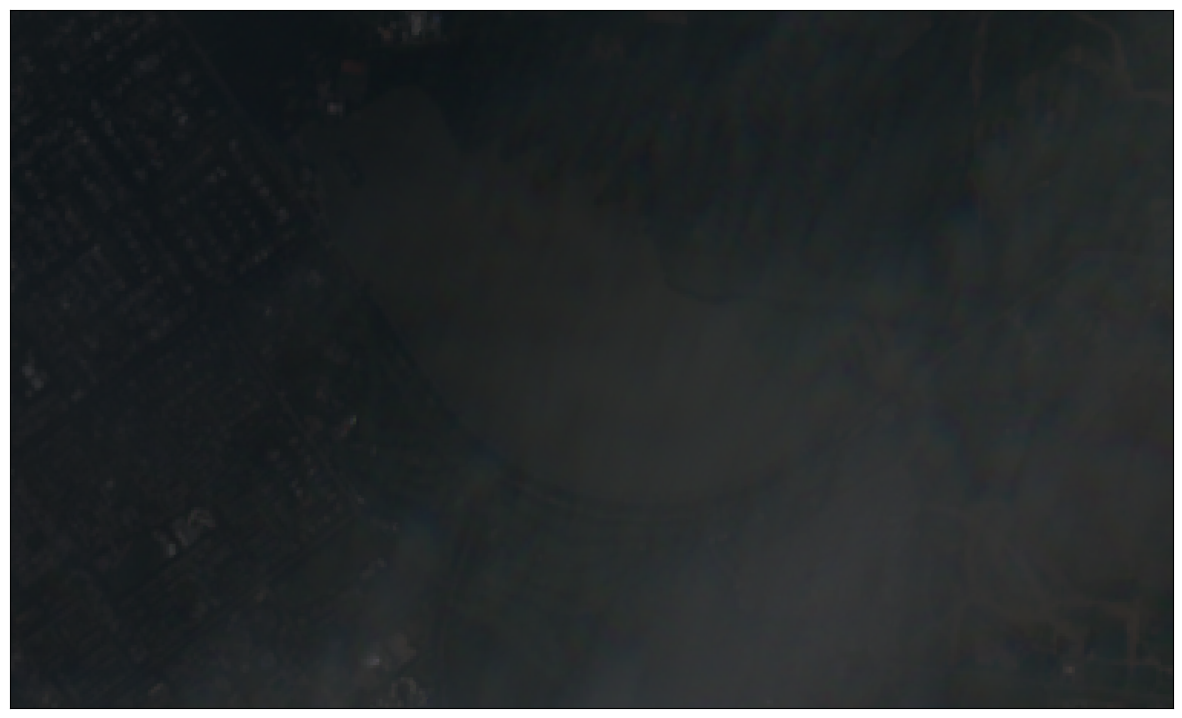

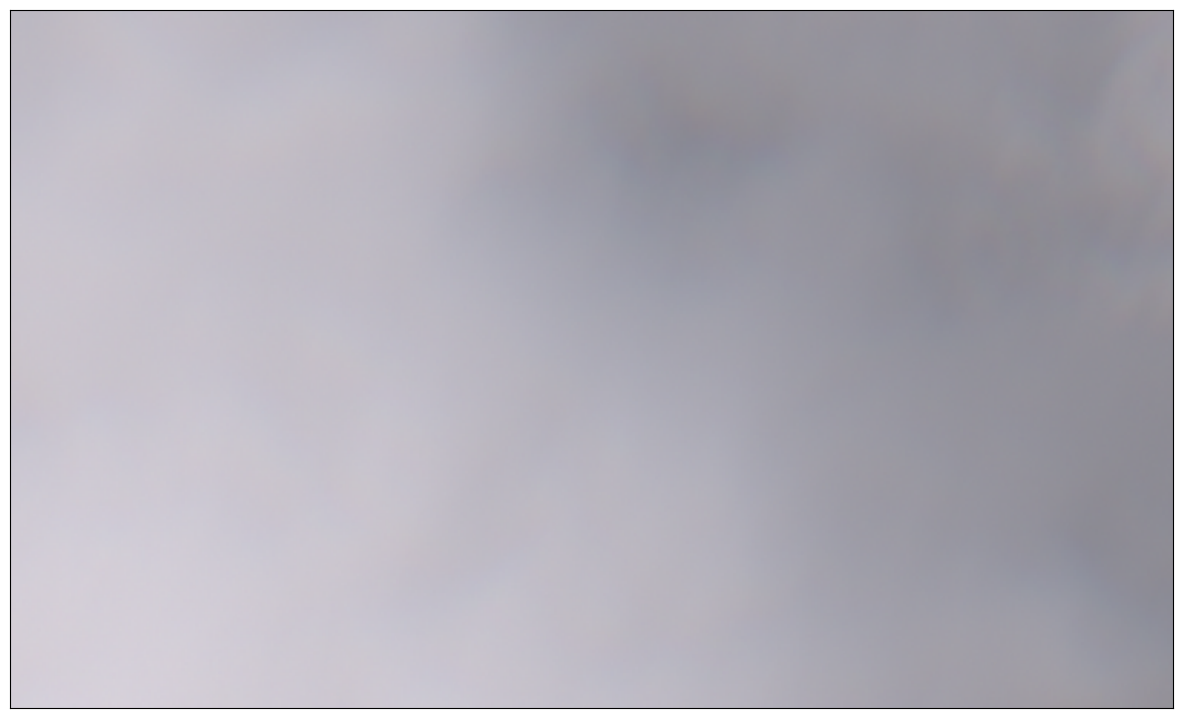

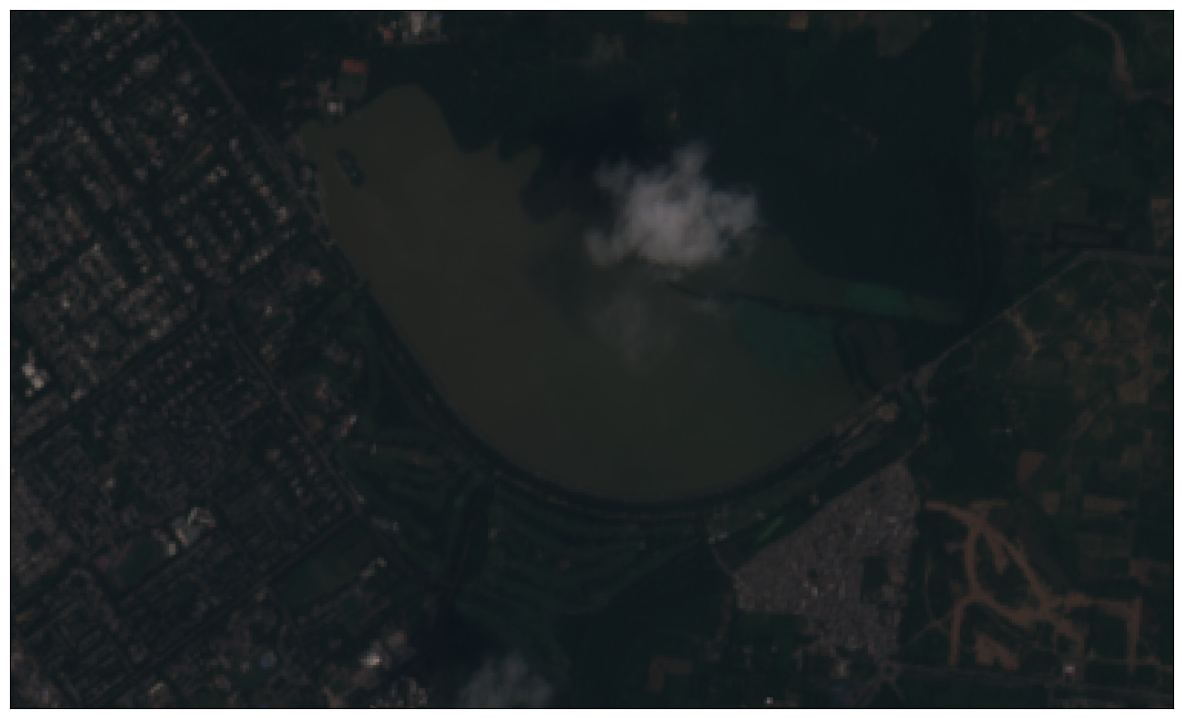

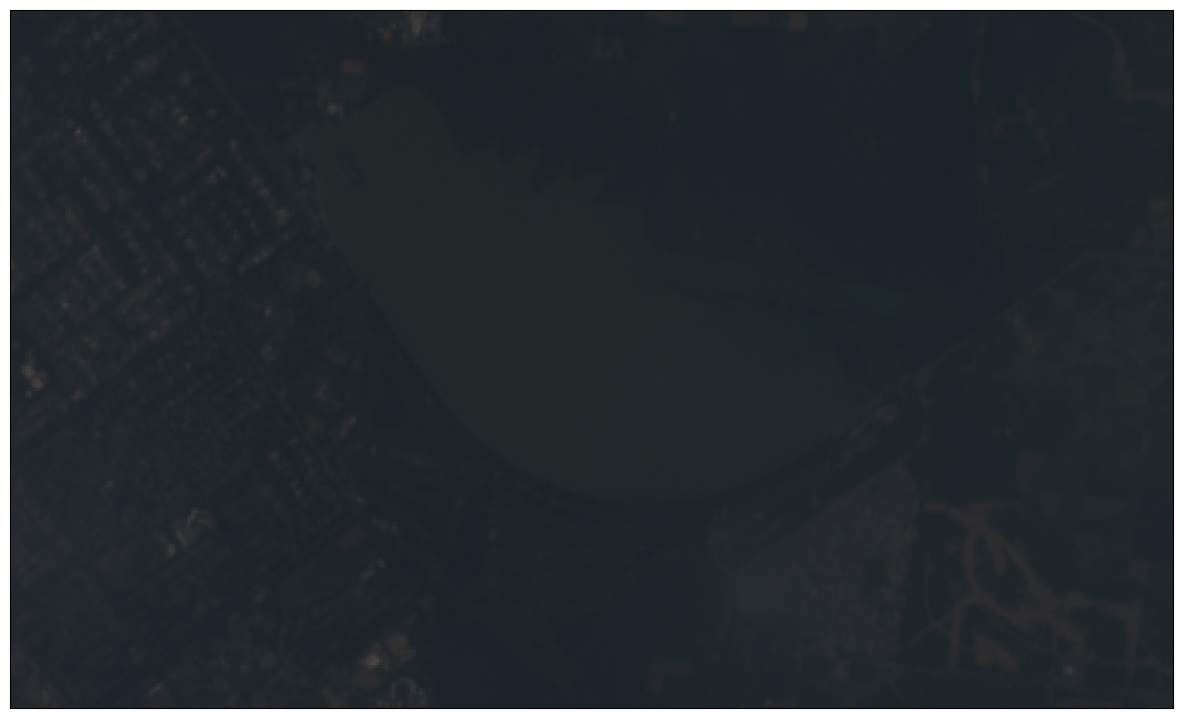

In [43]:
for i in range(len(images)):
    plot_image(images[i], factor=1 / 256, clip_range=(0, 1))

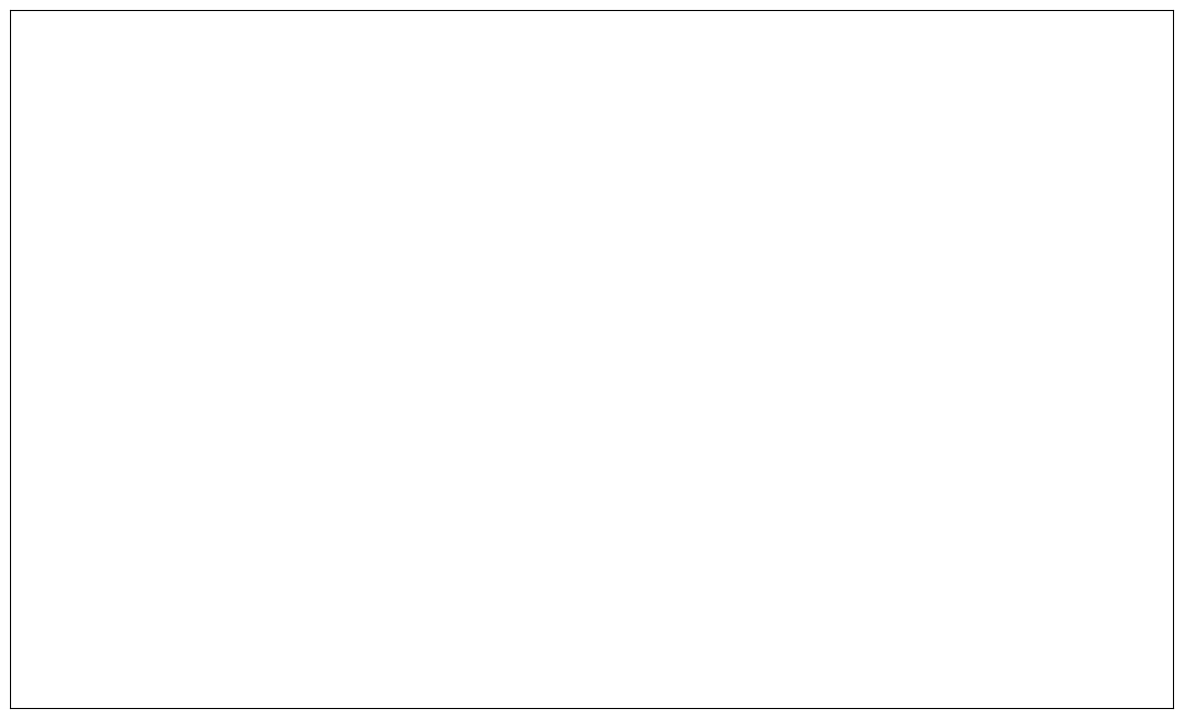

In [67]:
image = get_image('Sukhna lake', 'n', datetime(2020, 5, 29), config)
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))